In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [4]:
# some functions to deal with image 
def imload(image_name,**kwargs):       
    # a function to load image and transfer to Pytorch Variable.
    image = Image.open(image_name)
    if 'resize' in kwargs:
        resize = transforms.Resize(kwargs['resize'])
        image = resize(image)
    alpha = None
    # content 이미지의 배경 요소 제거 및 저장
    if len(image.getbands()) == 4: # Returns a tuple containing the name of each band in this image. 
        alpha = image.getchannel('A')
        image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),#Converts (H x W x C) of[0, 255] to (C x H x W) of range [0.0, 1.0]. 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # transforms.Normalize(mean, std, inplace=False): tensor의 데이터 수치(또는 범위)를 정규화    
    with torch.no_grad():
        image = Variable(transform(image)) # https://pytorch.org/docs/stable/autograd.html   variable 객체 지원 안됨   image의 type은 텐서
    image = image.unsqueeze(0) # x = torch.tensor([1, 2, 3, 4]) \  torch.unsqueeze(x, 0)  >>  tensor([[ 1,  2,  3,  4]])
    return image, alpha

In [5]:
class FeatureExtracter(nn.Module):
    # a nn.Module class to extract a intermediate activation of a Torch module
    def __init__(self,submodule): # submodule : 모델의 layer 가리키는 iterator
        super().__init__()
        self.submodule = submodule
    def forward(self,image,layers):
        features = []
        for i in range(layers[-1]+1):
            image = self.submodule[i](image)  
            if i in layers :
                features.append(image)       
        return features 

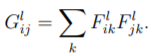

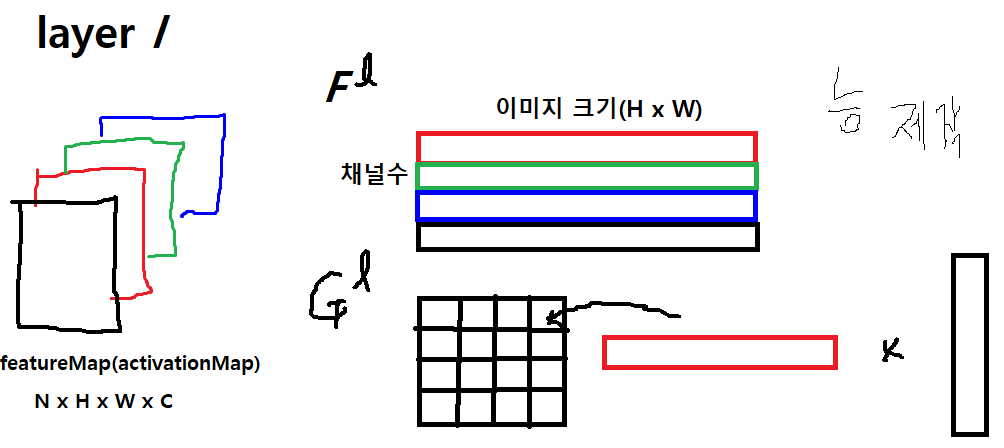

F{subscript}i,k{superscript}l : l layer의 i번째 채널의 k번째 pixel(activation) 값

G{subscript}i,j{superscript}l : l layer의 i 번째 featuremap과 j번째 featuremap의 내적값

G{superscript}l : l layer에서 F @ F.transpose  (채널수 x 채널수)

In [6]:
class GramMatrix(nn.Module):     
    # a nn.Module class to build gram matrix as style feature
    # gramMatrix : 동일 layer 내 feature들의 내적   하나의 layer에는 하나의 gramMatrix
    # gramMatrix의 크기 : 채널수 x 채널수  2차원 matrix
    def forward(self,style_features): 
        gram_Matrices=[]
        for feature in style_features:  # feature : 하나의 layer 내에서의 activation tensor들
            n,f,h,w = feature.size()  #  n : batch_size(1)   f : filter 수(channel 수)   h : height    w : width
            F = feature.resize(n*f,h*w) # 채널수 x 크기 

            gram_Matrices.append(( F @ F.t()).div_(2*n*f*h*w)) # div : 모든 픽셀에 대해 나눔
        return gram_Matrices

In [7]:
class Stylize(nn.Module): 
    # net 
    def forward(self,x):
        s_feats = feature(x,STYLE_LAYER)    # STYLE_LAYER에서 정의한 특정 layer들에서의 activation 값들 받아옴
        s_feats = gram(s_feats)
        c_feats = feature(x,CONTENT_LAYER)
        return s_feats,c_feats

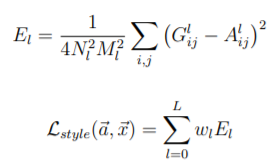

In [8]:
def totalloss(style_refs,content_refs,style_features,content_features,style_weight,content_weight):
    # compute total loss 
    style_loss_list = [l2loss(style_features[i],style_refs[i]) for i in range(len(style_features))] 
    
    # 이 부분 논문에서 정의한 style loss와 달라서 주석 처리함.  혹시 성능 안좋을 경우 이거 이용할 것
    #a small trick to balance the influnce of diffirent style layer
    mean_loss = sum(style_loss_list).item()/len(style_features)
    
    style_loss = sum([(mean_loss/l.item())*l*STYLE_LAYER_WEIGHTS[i] 
                    for i,l in enumerate(style_loss_list)])/len(style_features)                             
    '''
    style_loss = 0
    for i, loss in enumerate(style_loss_list):
        N, M = style_features[i].size()
        style_loss += (loss / (4 * ( N**2 * M**2 )))  *  STYLE_LAYER_WEIGHTS[i]
    '''
    content_loss = sum([l2loss(content_features[i],content_refs[i]) 
                    for i in range(len(content_refs))])  /  len(content_refs)

    total_loss = style_weight*style_loss   +   content_weight*content_loss 
    return total_loss

In [9]:
def reference(style_img,content_img):
    # a function to compute style and content refenrences as used for loss
    style_refs = feature(style_img,STYLE_LAYER)
    style_refs = gram(style_refs)
    style_refs = [Variable(i.data) for i in style_refs] # tensor.data  variable 객체가 tensor로 대체됨에 따라 필요없을 듯
    content_refs = feature(content_img,CONTENT_LAYER)
    content_refs = [Variable(i.data) for i in content_refs]
    return style_refs,content_refs

In [10]:
# init paramters
learning_rate = 1e-1
style_weight = 1e+0
content_weight = 1e-3
num_iters = 500

# load  pretrained squeezeNet and use the first sequential
model = models.squeezenet1_1(pretrained=True)
submodel = next(model.children()) # model.children() : 해당 모델의 전체 layer를 제공  # next : 다음 layer 가리키는 iteration

# load image
content_location = "/content/drive/MyDrive/Colab Notebooks/data/alpha.jpg"
style_location = "/content/drive/MyDrive/Colab Notebooks/data/style/la_muse.jpg"
style_img, _ = imload(style_location)
content_img, alpha = imload(content_location)

# set net parameter
STYLE_LAYER =[1,2,3,4,6,7,9]# could add more,maximal to 12    # 모델 내의 activation을 추출할 layer 선언
STYLE_LAYER_WEIGHTS = [21,21,1,1,1,7,7]# this should be small length as STYLE_LAYER    # layer에서의 오차를 얼만큼 강조할지 결정
CONTENT_LAYER = [1,2,3] 

# build net component
gram = GramMatrix()
feature = FeatureExtracter(submodel)    # STYLE_LAYER , CONTENT_LAYER에서 정의한 layer의 activation tensor를 받아옴
l2loss = nn.MSELoss(reduction='sum') 
stylize = Stylize()             # 
toImage = transforms.ToPILImage()

In [11]:
def getTransformedImg():
    train_img = Variable(torch.randn(content_img.size()),requires_grad = True) # 정규분포로 초기화  backward pass를 위해 tensor값 저장
    optimizer = optim.Adam([train_img], lr = learning_rate)
    style_refs,content_refs = reference(style_img,content_img) # style_refs : style_img를 model에 넣었을 때 STYLE_LAYER에서의 activation에 grammatrix 적용한 값
                                                            # content_refs : content_img를 model에 넣었을 때 CONTENT_LAYER에서의 activation 값
    for i in range(num_iters):
        optimizer.zero_grad() # gradients값들을 backward를 해줄때 계속 더하기 때문에 iteration마다 gradients를 zero로 초기화 해야함
        train_img.data.clamp_(-1,1)  # useful at first several step  # tensor 내 값들을 [ min, max ] 안으로 clamping(min-max scaling과 동일)
        style_features,content_features = stylize(train_img)  # train_img를 model에 넣었을 때 STYLE_LAYER에서의 activation에 grammatrix 적용한 값,  CONTENT_LAYER에서의 activation 값
        # content_img의 content 값, style_img의 style 값 // train_img에서의 content, style 값 을 통한 loss 계산
        loss = totalloss(style_refs,content_refs,style_features,content_features,style_weight,content_weight) 
        loss.backward() # autograd 를 사용하여 역전파 단계를 계산. 이는 requires_grad=True를 갖는 모든 텐서들에 대한 손실의 변화도를 계산한다.
        optimizer.step()  # 파라미터 갱신
    return train_img

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


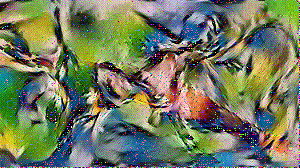

In [13]:
# main
styledImage = getTransformedImg() # tensor object
styledImage = toImage(styledImage[0].data*0.5+0.5)
if alpha is not None: # content image에 alpha 채널이 있는 경우에만 alpha 채널 추가
    styledImage.putalpha(alpha)
# styledImage.save("/content/drive/MyDrive/Colab Notebooks/data/test.png")
styledImage